<h1> Pitting Detection </h1>

First test without any preprocessing, using pretrained model Resnet18; 

18 layers:
1 convolutional + batch norm + ReLU layer
Followed by 8 residual blocks (each with 2 conv layers)
Ends with average pooling and a fully connected layer
Lightweight compared to deeper ResNets (like ResNet-50 or ResNet-101)
Fast and lightweight, good for small to medium datasets
Easy to train and less prone to overfitting
Often a go-to baseline for image tasks
Available in torchvision.models
Pretrained on ImageNet (over 1 million images, 1000 classes)
Can be fine-tuned for your custom dataset (e.g., 2-class pitting detection)

In [26]:
import numpy as np
import os
import cv2
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torchvision import models
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
from PIL import Image
import seaborn as sns 
import matplotlib.pyplot as plt 
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import torch.nn.functional as F


In [3]:
BASE = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

data_path = os.path.join(BASE, "data")

no_defect_simplified = os.listdir(os.path.join(data_path, "KGT_noDefect_simplified"))
pitting_simplified = os.listdir(os.path.join(data_path, "KGT_pitting_simplified"))

/var/folders/xt/qp4h10d92h76_sfj0rh4m3v00000gn/T/ipykernel_28506/984678031.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Folder', y='File Count', data=df, palette='Blues_d')


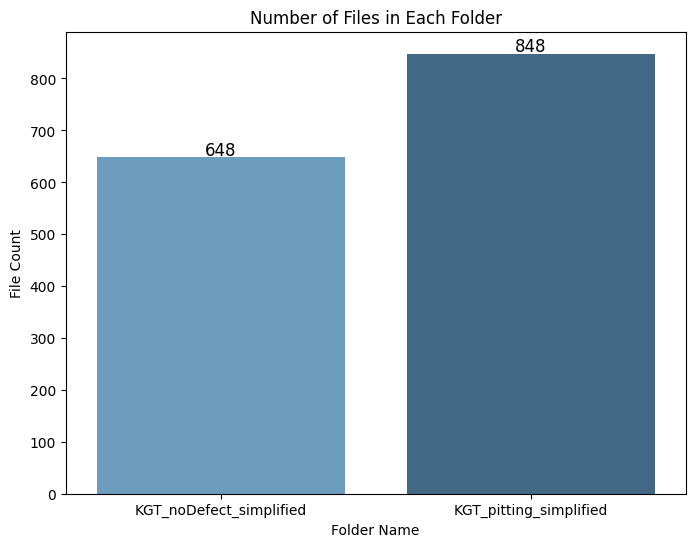

1496


In [4]:
df = pd.DataFrame({
    'Folder': ['KGT_noDefect_simplified', 'KGT_pitting_simplified'],
    'File Count': [len(no_defect_simplified), len(pitting_simplified)]
})

plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Folder', y='File Count', data=df, palette='Blues_d')

plt.title('Number of Files in Each Folder')
plt.xlabel('Folder Name')
plt.ylabel('File Count')

for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      fontsize=12, color='black', 
                      xytext=(0, 5), textcoords='offset points')

plt.show()

sum = len(no_defect_simplified) + len(pitting_simplified)
print(sum)

In [5]:
image = cv2.imread(os.path.join(data_path, "KGT_pitting_simplified",pitting_simplified[0]))
print(os.path.join(data_path, pitting_simplified[0]))
# Display the image
cv2.imshow('Image', image)

# Wait for a key press to close the window
cv2.waitKey(0)
cv2.destroyAllWindows()

/Users/janikwahrheit/Library/CloudStorage/OneDrive-Persönlich/01_Studium/01_Bachelor/06. SS_2025/Pitting_Detection/data/P (22).png


: 

: 

In [5]:
# Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

# Load dataset
dataset = datasets.ImageFolder(root=os.path.join(BASE, "dataset"), transform=transform)

# Split into train (80%) and test (20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [6]:
model = models.resnet18(pretrained=True)

# Modify the final layer for binary classification
model.fc = nn.Linear(model.fc.in_features, 2)

/Users/janikwahrheit/anaconda3/envs/pitting_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/janikwahrheit/anaconda3/envs/pitting_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")


Epoch 1, Loss: 8.3886
Epoch 2, Loss: 2.5284
Epoch 3, Loss: 0.6550
Epoch 4, Loss: 1.5182
Epoch 5, Loss: 0.3414
Epoch 6, Loss: 0.1453
Epoch 7, Loss: 0.0534
Epoch 8, Loss: 0.0412
Epoch 9, Loss: 0.0334
Epoch 10, Loss: 0.0288


In [ ]:
# Save model
torch.save(model.state_dict(), os.path.join(BASE, "models",  "resnet18_pitting.pth"))

In [55]:
#load model
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)  # 2 classes
model.load_state_dict(torch.load(os.path.join(BASE, "models/resnet18_pitting.pth")))
model.to(device)  # Send model to GPU/CPU
model.eval()  # Set to evaluation mode for inference



/Users/janikwahrheit/anaconda3/envs/pitting_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/janikwahrheit/anaconda3/envs/pitting_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

KeyboardInterrupt: 

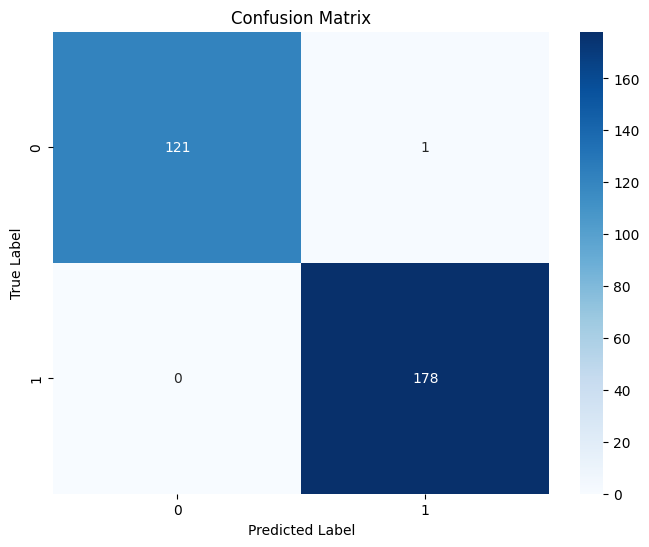

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [56]:
# load image 
image_path = os.path.join(BASE, "data/KGT_noDefect/N (446).png") 
image = Image.open(image_path)
image = transform(image).unsqueeze(0)  

# Move the image to the same device as the model
image = image.to(device)


# Predict
with torch.no_grad():
    outputs = model(image)

_, predicted_class = torch.max(outputs, 1)

print(f"Predicted class index: {predicted_class.item()}")

Predicted class index: 0


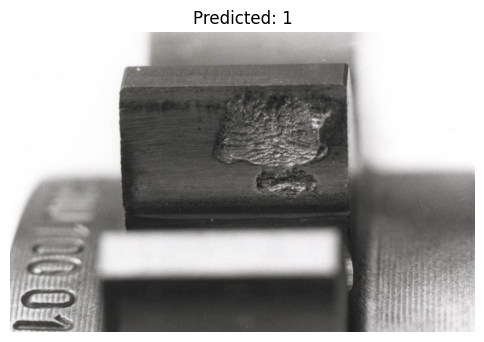

In [67]:
# Load the image
#image_path = os.path.join(BASE, "data/KGT_pitting_simplified/P (652).png") 
image_path= "/Users/janikwahrheit/Downloads/Oel_pit_h.jpg"

image = Image.open(image_path)


# Apply the transformations
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension (1, C, H, W)

# Move the image to the same device as the model
image_tensor = image_tensor.to(device)

# Make the prediction
with torch.no_grad():  # Turn off gradients to save memory
    outputs = model(image_tensor)

# Get the predicted class (the index of the max value in the output)
_, predicted_class = torch.max(outputs, 1)


# Display the image and the predicted label
plt.figure(figsize=(6, 6))
plt.imshow(np.array(image))  # Convert the image to a numpy array for displaying
plt.title(f'Predicted: {predicted_class.item()}')
plt.axis('off')  
plt.show()

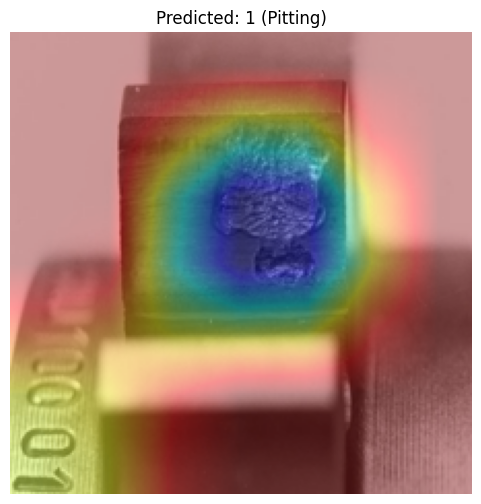

In [68]:
input_tensor = transform(image).unsqueeze(0).to(device)
#Hook for gradients
gradients = []

def save_gradient(grad):
    gradients.append(grad)

#Forward hook for activations
activations = []

def forward_hook(module, input, output):
    activations.append(output)
    output.register_hook(save_gradient)

# Register the hook to the last conv layer of ResNet18
target_layer = model.layer4
hook = target_layer.register_forward_hook(forward_hook)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax(dim=1).item()

#Backward pass for Grad-CAM 
model.zero_grad()
output[0, pred_class].backward()

# Get activations and gradients 
grads_val = gradients[0][0].cpu().detach().numpy()  # (C, H, W)
acts_val = activations[0][0].cpu().detach().numpy()  # (C, H, W)

# Compute the weights and CAM
weights = np.mean(grads_val, axis=(1, 2))  # Global average pooling
cam = np.zeros(acts_val.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * acts_val[i, :, :]

#Normalize and resize the CAM 
cam = np.maximum(cam, 0)  # ReLU
cam = cam - cam.min()
cam = cam / cam.max()
cam = cv2.resize(cam, (224, 224))

# Overlay the heatmap on the image 
img_np = np.array(image.resize((224, 224)))  # Original image
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
inverted_heatmap = cv2.bitwise_not(heatmap)
overlay = heatmap * 0.4 + img_np * 0.6
overlay = np.uint8(overlay)

# Show the result 
plt.figure(figsize=(6, 6))
plt.imshow(overlay)
plt.title(f"Predicted: {pred_class} ({'Pitting' if pred_class == 1 else 'No Defect'})")
plt.axis('off')
plt.show()

# Cleanup
hook.remove()

In [49]:
cv2.COLORMAP_JET

2

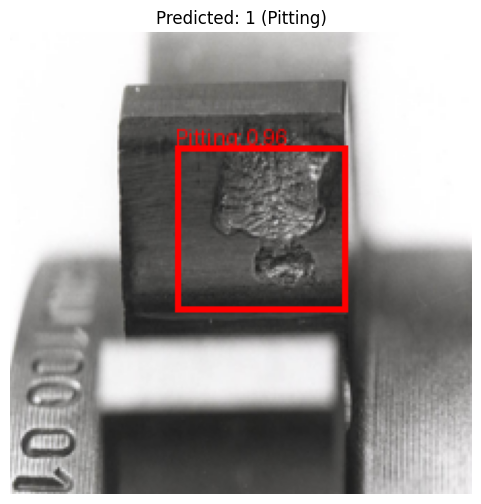

In [69]:
# Forward/Backward Hooks for Grad-CAM 
gradients = []
activations = []

def save_gradient(grad):
    gradients.append(grad)

def forward_hook(module, input, output):
    activations.append(output)
    output.register_hook(save_gradient)

# Register hook to last conv layer
hook = model.layer4.register_forward_hook(forward_hook)

# Forward pass 
model.eval()
output = model(input_tensor)
probs = F.softmax(output, dim=1)
pred_class = output.argmax(dim=1).item()
confidence = probs[0, pred_class].item()

# Backward pass 
model.zero_grad()
output[0, pred_class].backward()

# Grad-CAM logic
grads_val = gradients[0][0].cpu().numpy()
acts_val = activations[0][0].detach().cpu().numpy()


weights = np.mean(grads_val, axis=(1, 2))
cam = np.zeros(acts_val.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * acts_val[i, :, :]

cam = np.maximum(cam, 0)
cam = cam - cam.min()
cam = cam / cam.max()
cam = cv2.resize(cam, (224, 224))

# Threshold and find bounding box
threshold = 0.6  # You can adjust this
binary_cam = (cam > threshold).astype(np.uint8)
contours, _ = cv2.findContours(binary_cam, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert original image for drawing
draw_img = image.resize((224, 224)).copy()
draw = ImageDraw.Draw(draw_img)

if contours:
    # Find the largest contour
    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)
    
    # Draw rectangle and label
    draw.rectangle([x, y, x + w, y + h], outline="red", width=3)
    label = f"{'Pitting' if pred_class == 1 else 'No Defect'}: {confidence:.2f}"
    draw.text((x, y - 10), label, fill="red")

# Show image with bounding box
plt.figure(figsize=(6, 6))
plt.imshow(draw_img)
plt.axis('off')
plt.title(f"Predicted: {pred_class} ({'Pitting' if pred_class == 1 else 'No Defect'})")
plt.show()

hook.remove()

<h1> Next Steps </h1>

Accuracy of 0.99 might indicate overfitting. 

- randomly rotate, resize and crop images 
- preprocessing 
- regularization 
- dropout 
- early stoppingh 
- cross validation 
- use other pretrained models, do not use a pretrained model 
- batch normalization 